<a href="https://colab.research.google.com/github/GdoongMathew/Google_Landmark_Recognition_2021/blob/main/training_aucface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install efficientnet -q
!pip install -U git+https://github.com/GdoongMathew/EfficientNetV2 --no-deps
!pip install fsspec
!pip install gcsfs

  Cloning https://github.com/GdoongMathew/EfficientNetV2 to /tmp/pip-req-build-1haga296
  Running command git clone -q https://github.com/GdoongMathew/EfficientNetV2 /tmp/pip-req-build-1haga296


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.mixed_precision import experimental as mixed_precision
# from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm
import efficientnetv2 as efnv2
# import tensorflow.keras.applications.xception as xcept
import efficientnet.tfkeras as efn


from sklearn.model_selection import KFold

import re
import os
import io
import time
import pickle
import math
import random
import sys

print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow keras version: {tf.keras.__version__}')
print(f'python version: P{sys.version}')

tensorflow version: 2.6.0
tensorflow keras version: 2.6.0
python version: P3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [3]:
# Seed all random number generators
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [4]:
GCS_DS_PATH_1 = 'gs://kds-d36965c71f1aba91ef7a2904c04ed5d71407e6cbcc88de690f93bdda'
GCS_DS_PATH_2 = 'gs://kds-ab101f0bc8bef40c66229723dae46eb3cebe1c43d19df839b985153b'
GCS_DS_PATH_3 = 'gs://kds-2f531983451093758fb7f53b2c108f3c640609fb9276735c7725e75b'
GCS_DS_PATH_4 = 'gs://kds-e2ecb8c94994392b4f693b80830db7d7418a02e1ca08946d3f060fd7'
GCS_DS_PATH_5 = 'gs://kds-339d2b166669775eda09e16316f0e8c48c8435ba7db037bb56bdc9ed'

In [5]:
all_files = []
for path in [GCS_DS_PATH_1, GCS_DS_PATH_2, GCS_DS_PATH_3, GCS_DS_PATH_4, GCS_DS_PATH_5]:
    all_files.extend(np.sort(np.array(tf.io.gfile.glob(path + "/*.tfrec"))))

print("train files: ", len(all_files))

train files:  60


In [6]:
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        strategy = tf.distribute.get_strategy()
        tpu = None
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy, tpu

In [7]:
strategy, tpu = auto_select_accelerator()
REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.125.27.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.125.27.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Running on TPU: grpc://10.125.27.154:8470
Running on 8 replicas


In [8]:
DEBUG = False

SEED = 42
seed_everything(SEED)

# Image dimensions
IMAGE_SIZE = 640#384
N_CHANNELS = 3
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)
NUM_FOLDS = 5

N_CLASSES = 81313

EMBEDDING_DIM = 768

# EfficientNet version, s, l, xl, xxl
EFN_SIZE = 's'
 
# Batch size per replica, there are 8 replicas resulting in a batch size of 1024
BATCH_SIZE_BASE = 6 if DEBUG else (4 if tpu else 16)
BATCH_SIZE = BATCH_SIZE_BASE * REPLICAS

MODEL_POLICY = 'mixed_bfloat16' # float32 or mixed_bfloat16
IMAGE_DTYPE = tf.bfloat16 if MODEL_POLICY == 'mixed_bfloat16' else tf.float32
LABEL_DTYPE = tf.int32

# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE

print(f'BATCH_SIZE: {BATCH_SIZE}, IMAGE_DTYPE: {IMAGE_DTYPE}, LABEL_DTYPE: {LABEL_DTYPE}')
print(f'MODEL_POLICY: {MODEL_POLICY}')

BATCH_SIZE: 32, IMAGE_DTYPE: <dtype: 'bfloat16'>, LABEL_DTYPE: <dtype: 'int32'>
MODEL_POLICY: mixed_bfloat16


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
df = pd.read_csv('/content/drive/MyDrive/google_landmark_2021/train.csv')
tmp = np.sqrt(1 / np.sqrt(df['landmark_id'].value_counts().sort_index().values))
margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * 0.15 + 0.15

In [11]:
def keras_aug(dataset: tf.data.Dataset):
    keras_aug_layers = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.05, 0.05), fill_mode='constant'),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='constant'),
    ])
    
    @tf.function(jit_compile=True)
    def apply_aug(x, y):
        # x = keras_aug_layers(x, training=True)
        return keras_aug_layers(x, training=True), y

    dataset = dataset.map(apply_aug, num_parallel_calls=AUTO)
    return dataset

In [12]:
@tf.function(jit_compile=True)
def tf_aug(image, label):
    image = tf.image.random_flip_left_right(image, seed=SEED)
    # image = tf.image.random_flip_up_down(image, seed=SEED)
    image = tf.image.random_saturation(image, 0.8, 1)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.0, seed=SEED)

    resize_factor = int((IMAGE_SIZE // 5) * 6)
    image = tf.image.resize_with_crop_or_pad(image, resize_factor, resize_factor)
    image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3])
    # image = tf.image.random_jpeg_quality(image, 85, 100, seed=SEED)
    return image, label

In [13]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, size=(IMAGE_SIZE, IMAGE_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    if image.dtype != IMAGE_DTYPE:
        image = tf.cast(image, IMAGE_DTYPE)
    return image


def read_labeled_tfrecord(example):
    tfrec_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
    }

    example = tf.io.parse_single_example(example, tfrec_format)
    posting_id = example["image_name"]
    image = decode_image(example["image"])
    label_group = tf.cast(example["target"], tf.int32)
    return image, label_group


def arcface_format(image, label_group):
    # image = tf.cast(image, IMAGE_DTYPE) if image.dtype != IMAGE_DTYPE else image
    return {'image': image, 'label': label_group}, label_group

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, batch_size=64, cache=False, repeat=False, shuffle=False, augment=True):        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    opt = tf.data.Options()
    opt.experimental_deterministic = False

    dataset = dataset.with_options(opt)
    if cache:
        dataset = dataset.cache()

    if shuffle:
        dataset = dataset.shuffle(2048)

    if repeat:
        dataset = dataset.repeat()

    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO) 
    if augment:
        dataset = dataset.map(tf_aug, num_parallel_calls=AUTO) 

    dataset = dataset.batch(batch_size * REPLICAS)
    # if augment:
    #     dataset = keras_aug(dataset)

    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)
    dataset = dataset.prefetch(AUTO)
    return dataset


def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(all_files)
NUM_TRAINING_IMAGES

1580470

In [15]:
# Plots a batch of images
def show_batch(dataset, rows=4, cols=3):
    inputs, lbls = next(iter(dataset))
    imgs = inputs['image']
    print(imgs.dtype)
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*7, rows*4))
    for r in range(rows):
        for c in range(cols):
            img = imgs[r*cols+c].numpy().astype(np.float32)
            img += abs(img.min())
            img /= img.max()
            axes[r, c].imshow(img)
            axes[r, c].set_title(f'Label: {np.argmax(lbls[r*cols+c])}')

<dtype: 'bfloat16'>


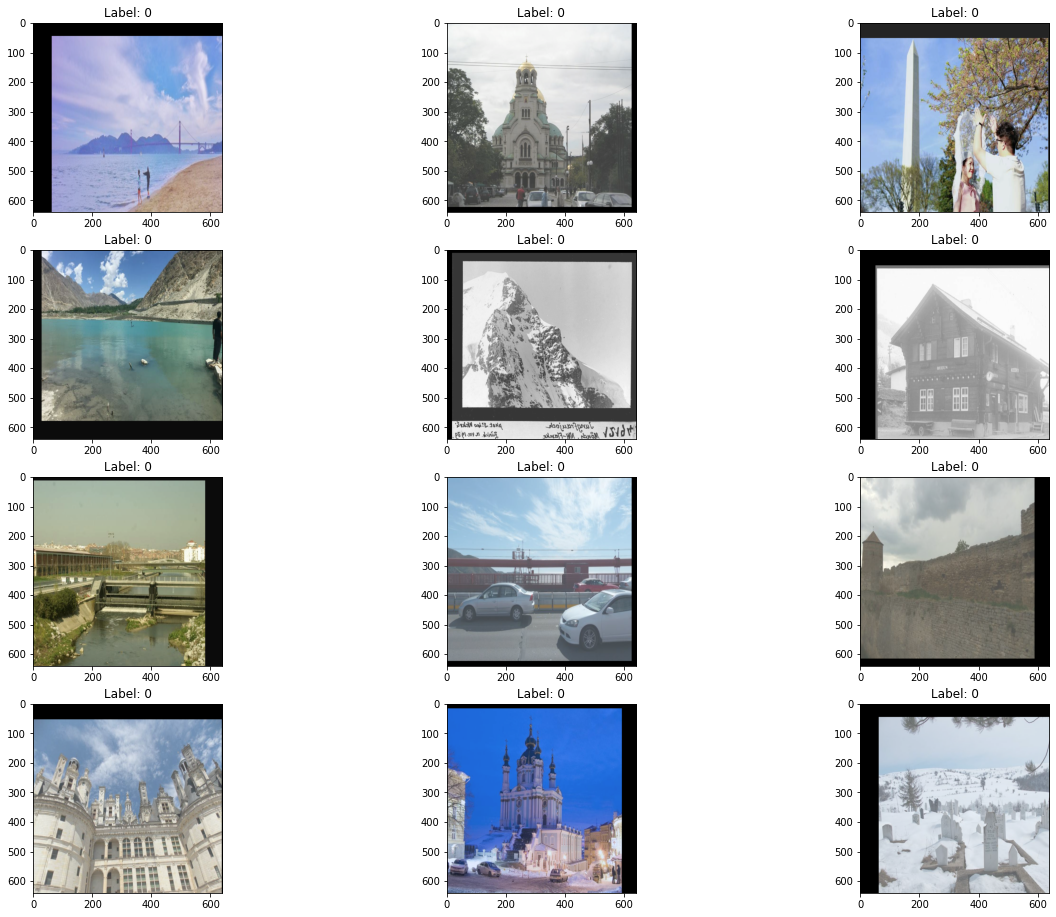

In [16]:
ds = load_dataset(all_files[:50], augment=True)
show_batch(ds)

# ArcMargin Product

In [17]:
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False, ls_eps=0.0, topk=3, **kwargs):
        
        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m
        self.topk = topk
        
    def get_config(self):
        config = super(ArcMarginProduct, self).get_config()
        return {**config, 
                'n_classes': self.n_classes, 
                's': self.s, 
                'm': self.m,
                'easy_margin': self.easy_margin,
                'ls_eps': self.ls_eps,
                'topk': self.topk
               }

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes * self.topk),
            initializer='glorot_uniform',
            dtype=tf.float32,
            trainable=True,
            regularizer=None
        )

    def call(self, inputs):
        X, y = inputs
        
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        if self.topk > 1:
            cosine = tf.reshape(cosine, (-1, self.n_classes, self.topk))
            cosine = tf.reduce_max(cosine, axis=2)

        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

In [18]:
class ArcMarginProductDyn(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, margins, s=30, easy_margin=False, ls_eps=0.0, topk=3, **kwargs):
        
        super(ArcMarginProductDyn, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.margins = margins
        self.tf_margins = tf.constant(margins, dtype=tf.float32)
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.s = 3
        self.topk = topk
        
    def get_config(self):
        config = super(ArcMarginProductDyn, self).get_config()
        return {**config, 
                'n_classes': self.n_classes, 
                'margins': self.margins,
                's': self.s, 
                'easy_margin': self.easy_margin,
                'ls_eps': self.ls_eps,
                'topk': self.topk
               }

    def build(self, input_shape):
        super(ArcMarginProductDyn, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes * self.topk),
            initializer='glorot_uniform',
            dtype=tf.float32,
            trainable=True,
            regularizer=None
        )

    def call(self, inputs):
        X, y = inputs
        
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        if self.topk > 1:
            cosine = tf.reshape(cosine, (-1, self.n_classes, self.topk))
            cosine = tf.reduce_max(cosine, axis=2)
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
            
        ms = tf.reshape(tf.gather(self.tf_margins, indices=y), (-1, 1))
        cos_m = tf.math.cos(ms)
        sin_m = tf.math.sin(ms)
        
        th = tf.math.cos(math.pi - ms)
        mm = tf.math.sin(math.pi - ms) * ms
        
        phi = cosine * cos_m - sine * sin_m
        phi = tf.where(cosine > th, phi, cosine - mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        
        return output

In [19]:
class GeMPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, init_norm=3.0, normalize=False, **kwargs):
        self.init_norm = init_norm
        self.normalize = normalize

        super(GeMPoolingLayer, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'init_norm': self.init_norm,
            'normalize': self.normalize,
        })
        return config

    def build(self, input_shape):
        feature_size = input_shape[-1]
        self.p = self.add_weight(name='norms', shape=(feature_size,),
                                 initializer=tf.keras.initializers.constant(self.init_norm),
                                 trainable=True)
        super(GeMPoolingLayer, self).build(input_shape)

    def call(self, inputs):
        x = inputs
        x = tf.math.maximum(x, 1e-6)
        x = tf.pow(x, self.p)

        x = tf.reduce_mean(x, axis=[1, 2], keepdims=False)
        x = tf.pow(x, 1.0 / self.p)

        if self.normalize:
            x = tf.nn.l2_normalize(x, 1)
        return x

    def compute_output_shape(self, input_shape):
        return tuple([None, input_shape[-1]])

In [20]:
def get_model(weights=None):
    tf.keras.backend.clear_session()
    # enable XLA optmizations
    tf.config.optimizer.set_jit(True)
    
    # set half precision policy
    mixed_precision.set_policy(MODEL_POLICY)

    # Print compute and variable dtype, on TPUINPUT_SHAPEthis will be bfloat16 for compute and float32 for variable
    print(f'Compute dtype: {mixed_precision.global_policy().compute_dtype}')
    print(f'Variable dtype: {mixed_precision.global_policy().variable_dtype}')

    with strategy.scope():
        backbone_weights = weights if 'imagenet' in weights else None

        # Inputs, note the names are equal to the dictionary keys in the dataset
        image = tf.keras.layers.Input((None, None, 3), name='image')
        backbone = efnv2.EfficientNetV2_S(input_tensor=image, weights=backbone_weights, include_top=False, pooling=None)
        # backbone = efn.EfficientNetB5(input_shape=(None, None, 3), weights=backbone_weights, include_top=False, pooling=None)
        # backbone = xcept.Xception(input_tensor=image, weights=backbone_weights, include_top=False, pooling=None)
        print('backbone finished')
        
        label = tf.keras.layers.Input([], name='label', dtype=tf.int32)

        # CNN call, we need only the output layer
        x = backbone(image, training=True)

        # GeMPoolingLayer
        x = GeMPoolingLayer()(x)

        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(EMBEDDING_DIM, name="dense_before_arcface", kernel_initializer="he_normal")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        # ArcMargin product
        x = ArcMarginProduct(n_classes=N_CLASSES,
                             m=0.3,
                             s=64, 
                             name='arc_margin', 
                             dtype=tf.float32, topk=2)([x, label])
        # x = ArcMarginProductDyn(N_CLASSES,
        #                         margins,
        #                         s=64, 
        #                         name='arc_margin', 
        #                         dtype=tf.float32, topk=2)([x, label])

        output = tf.keras.layers.Activation('softmax', dtype="float32")(x)
        model = tf.keras.models.Model(inputs = [image, label], outputs = output)

        if 'imagenet' not in weights:
            model.load_weights(weights)

        # We will use the famous Adam optimizer for fast learning
        optimizer = tf.keras.optimizers.Adam()

        # Categorical Cross Entropy loss, from_logits=True so no softmax needed
        loss = tf.keras.losses.SparseCategoricalCrossentropy()

        # To track learning progress, top 1/10/100/1000 accuracies will be kept track of
        metrics = [
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name='accuracy@1'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='accuracy@10'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=100, name='accuracy@100'),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1000, name='accuracy@1000'),
        ]

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        return model

In [21]:
# returns the learning rate given an epoch number
def lrfn(epoch):
    # Config

    # 384
    # LR_START = 2e-5 # start of learning rate
    # LR_MAX = 8e-4 # peak learning rate
    # LR_FINAL = 1e-5 # final learning rate

    LR_RAMPUP_EPOCHS = 3 # number of exponential warmup epochs
    LR_SUSTAIN_EPOCHS = 2 # number of epochs at maximum learning rate

    LR_START = 8e-5 # start of learning rate
    LR_MAX = 4e-4 # peak learning rate
    LR_FINAL = 1e-4 # final learning rate
    
    LR_RAMPUP_EPOCHS = 3 # number of exponential warmup epochs
    LR_SUSTAIN_EPOCHS = 2 # number of epochs at maximum learning rate
    
    DECAY_EPOCHS = EPOCHS  - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
    LR_EXP_DECAY = (LR_FINAL / LR_MAX) ** (1 / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1))

    if epoch < LR_RAMPUP_EPOCHS: # exponential warmup
        lr = LR_START + (LR_MAX + LR_START) * (epoch / LR_RAMPUP_EPOCHS) ** 2.5
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS: # sustain lr
        lr = LR_MAX
    else: # cosine decay
        epoch_diff = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS + 1
        decay_factor = (epoch_diff / (DECAY_EPOCHS + 1)) * math.pi
        decay_factor= (tf.math.cos(decay_factor).numpy() + 1) / 2
        lr = LR_FINAL + (LR_MAX - LR_FINAL) * decay_factor

    return round(lr, 8)

In [22]:
# Due to the huge batch size of 1024 and usage of bfloat16 15 epochs are possible in a single run!
EPOCHS = 2 if DEBUG else 15 #25

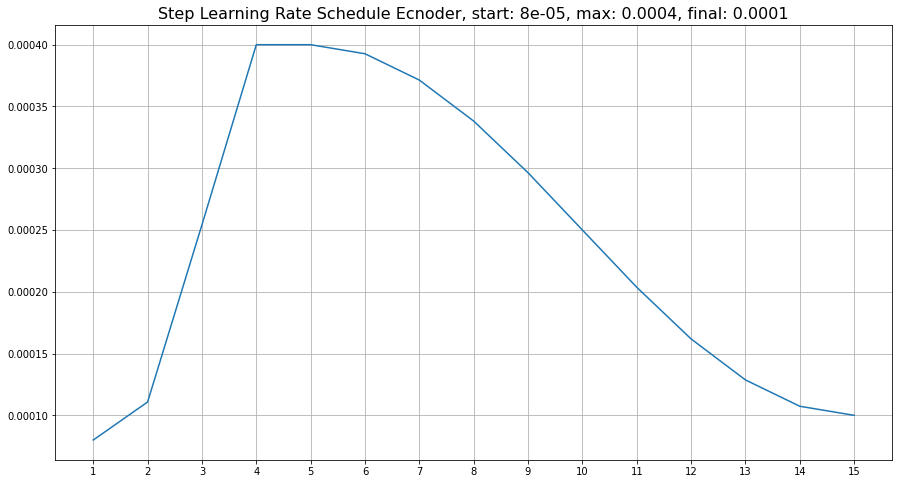

In [23]:
# Plots the learning rate schedule
def plot_lr_schedule(lr_schedule, name):
    plt.figure(figsize=(15,8))
    plt.plot(lr_schedule)
    x = np.arange(EPOCHS)
    x_axis_labels = list(map(str, np.arange(1, EPOCHS+1)))
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    schedule_info = f'start: {lr_schedule[0]}, max: {max(lr_schedule)}, final: {lr_schedule[-1]}'
    plt.title(f'Step Learning Rate Schedule {name}, {schedule_info}', size=16)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step) for step in range(EPOCHS)]
plot_lr_schedule(LR_SCHEDULE, 'Ecnoder')

In [24]:
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
files_train_all = np.array(all_files)

In [ ]:
target_fold = [2]
for fold, (trn_idx, val_idx) in enumerate(kf.split(files_train_all)):
    if fold not in target_fold:
        continue

    files_train = files_train_all[trn_idx]
    files_valid = files_train_all[val_idx]

    print("=" * 120)
    print(f"Fold {fold}")
    print("=" * 120)

    train_image_count = count_data_items(files_train)
    valid_image_count = count_data_items(files_valid)

    model = get_model(weights=f'/content/drive/MyDrive/google_landmark_2021/EffnetV2_S_Arcface_GeM_model{fold}_{IMAGE_SIZE}.h5')

    model_ckpt = tf.keras.callbacks.ModelCheckpoint(
        f'/content/drive/MyDrive/google_landmark_2021/EffnetV2_S_Arcface_GeM_model{fold}_{IMAGE_SIZE}.h5',
        monitor="val_loss", verbose=1, save_best_only=False
    )

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: lrfn(step), verbose=1)


    train_dataset = load_dataset(files_train, batch_size=BATCH_SIZE, shuffle=True, repeat=True, augment=True)
    valid_dataset = load_dataset(files_valid, batch_size=BATCH_SIZE, shuffle=False, repeat=False, augment=False)

    STEPS_PER_EPOCH = train_image_count // BATCH_SIZE // REPLICAS
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        initial_epoch=5,
        callbacks=[lr_callback, model_ckpt],
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=valid_dataset,
        verbose=1
    )

Fold 2
Compute dtype: bfloat16
Variable dtype: float32
backbone finished
Epoch 6/15

Epoch 00006: LearningRateScheduler setting learning rate to 0.00039266.
4940/4940 [==============================] - 8240s 2s/step - loss: 1.8575 - accuracy@1: 0.7158 - accuracy@10: 0.8753 - accuracy@100: 0.9371 - accuracy@1000: 0.9677 - val_loss: 8.4727 - val_accuracy@1: 0.2790 - val_accuracy@10: 0.4279 - val_accuracy@100: 0.5526 - val_accuracy@1000: 0.6664

Epoch 00006: saving model to /content/drive/MyDrive/google_landmark_2021/EffnetV2_S_Arcface_GeM_model2_640.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15

Epoch 00007: LearningRateScheduler setting learning rate to 0.00037135.
4940/4940 [==============================] - 7833s 2s/step - loss: 1.5290 - accuracy@1: 0.7651 - accuracy@10: 0.9012 - accuracy@100: 0.9501 - accuracy@1000: 0.9742 - val_loss: 8.2893 - val_accuracy@1: 0.2880 - val_accuracy@10: 0.4407 - val_accuracy@100: 0.5676 - val_accuracy@1000: 0.6800

Epoch 00007: saving model to /content/drive/MyDrive/google_landmark_2021/EffnetV2_S_Arcface_GeM_model2_640.h5
Epoch 8/15

Epoch 00008: LearningRateScheduler setting learning rate to 0.00033817.
4940/4940 [==============================] - 7849s 2s/step - loss: 1.3149 - accuracy@1: 0.7931 - accuracy@10: 0.9183 - accuracy@100: 0.9594 - accuracy@1000: 0.9792 - val_loss: 8.0881 - val_accuracy@1: 0.3025 - val_accuracy@10: 0.4582 - val_accuracy@100: 0.5843 - val_accuracy@1000: 0.6949

Epoch 00008: saving model to /content/drive/MyDrive/google_landmark_2021/EffnetV2_S_Arcface_GeM_model2_640.h5
Epoch 9/15

Epoch 00009: Learnin

In [ ]:
# Function to plot the metric history
def plot_history_metric(history, metric, f_best):
    plt.figure(figsize=(15, 8))
    N_EPOCHS = len(history.history['loss'])
    x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]
    x_ticks = np.arange(1, N_EPOCHS+1)
    # summarize history for accuracy
    plt.plot(x_ticks, history.history[metric])
    values = history.history[metric]
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=50, marker='o')
    
    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)
    plt.xlabel('epoch', fontsize=20, labelpad=10)
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    plt.legend(['train'],  prop={'size': 18})
    plt.grid()

In [ ]:
plot_history_metric(history, 'loss', np.argmin)

In [ ]:
plot_history_metric(history, 'accuracy@1', np.argmax)

In [ ]:
plot_history_metric(history, 'accuracy@10', np.argmax)

In [ ]:
plot_history_metric(history, 'accuracy@100', np.argmax)

In [ ]:
plot_history_metric(history, 'accuracy@1000', np.argmax)